In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as LA

from qiskit import(
    QuantumCircuit,
    ClassicalRegister, 
    QuantumRegister,
    transpile)

from qiskit.circuit.library import UnitaryGate

from qiskit.providers.basic_provider import BasicProvider
# from qiskit_ionq import IonQProvider, GPIGate, GPI2Gate, ZZGate

backend = BasicProvider().get_backend('basic_simulator')
# provider = IonQProvider()
# backend_native = provider.get_backend("simulator", gateset='native')

In [2]:
x = np.array([[0, 1], [1, 0]], dtype='complex')
y = np.array([[0, -1j], [1j, 0]], dtype='complex')
Id = np.identity(2)
op = np.kron(Id, x) @ np.kron(y, Id) - np.kron(Id, y) @ np.kron(x, Id)

def givens_circ(theta):
    mat = LA.expm(1j/2 * theta * op)
    qreg = QuantumRegister(2)
    circ = QuantumCircuit(2)
    circ.append(UnitaryGate(mat), [0, 1])
    return circ

def givens_circ_conj(theta):
    mat = LA.expm(1j/2 * theta * op).conjugate().transpose()
    qreg = QuantumRegister(2)
    circ = QuantumCircuit(2)
    circ.append(UnitaryGate(mat), [0, 1])
    return circ

givens_circ(3 * np.pi/4).decompose().draw()

global phase: 5.1385
      ┌─────────────────┐            ┌───────────────┐           »
q_0: ─┤ U(π/2,π/2,-π/8) ├────■───────┤ U(3π/4,0,π/2) ├────────■──»
     ┌┴─────────────────┴─┐┌─┴─┐┌────┴───────────────┴─────┐┌─┴─┐»
q_1: ┤ U(1.4697,π/2,3π/8) ├┤ X ├┤ U(1.5414,1.4993,-2.3515) ├┤ X ├»
     └────────────────────┘└───┘└──────────────────────────┘└───┘»
«       ┌─────────────────┐   
«q_0: ──┤ U(π/2,-7π/8,-π) ├───
«     ┌─┴─────────────────┴──┐
«q_1: ┤ U(0.10111,5π/8,-π/2) ├
«     └──────────────────────┘

In [3]:
N_s = 8
N_t = 40
lam = 0.3
hL = 0.2
dt = 0.2
N_t * dt

8.0

In [4]:
betas_r = np.array([-0.        ,  1.17809725,  2.35619449, -2.74889357, -1.57079633,
       -0.39269908,  0.78539816,  1.96349541])
 
angles_r = [-1.4628495506187855,
 -1.565996515216672,
 -1.4634742646356191,
 -0.7912076450496149,
 -0.35874202677184114,
 -0.6004336402695971,
 -1.0841937949333018]

betas_l = np.array([-0.        , -1.17809725, -2.35619449,  2.74889357,  1.57079633,
        0.39269908, -0.78539816, -1.96349541])

angles_l = [-0.25773446551775,
 -0.5855168312244513,
 -1.080026981562255,
 -1.4471950915873049,
 -1.5574367790972365,
 -1.5702011576656814,
 -1.5574379734927726]

In [5]:
def make_circuit(t_step):
    qreg = QuantumRegister(N_s)
    creg = ClassicalRegister(N_s)
    circ = QuantumCircuit(qreg, creg)

    # State-Prep
    ## Right moving wave packet
    ### V^dag
    for i in range(N_s):
        circ.rz(betas_r[i], i)
    for i in range(N_s-1):
        j = N_s - 1 - i
        circ.append(givens_circ(angles_r[i]), [j-1, j])
    ###
    circ.x(0)
    ### V
    for i in range(1, N_s):
        j = N_s - 1 - i
        circ.append(givens_circ_conj(angles_r[j]), [i-1, i])
    for i in range(N_s):
        circ.rz(-betas_r[i], i)
    ###
    
    ## Left Moving Wave Packet
    # V^dag
    for i in range(N_s):
        circ.rz(betas_l[i], i)
    for i in range(N_s-1):
        j = N_s - 1 - i
        circ.append(givens_circ(angles_l[i]), [j-1, j])
    ###
    circ.x(0)
    ### V
    for i in range(1, N_s):
        j = N_s - 1 - i
        circ.append(givens_circ_conj(angles_l[j]), [i-1, i])
    for i in range(N_s):
        circ.rz(-betas_l[i], i)
    
    # Trotter Evolution
    for i in range(t_step):
        # Transverse Field
        for j in range(N_s):
            circ.rz(-2 * dt, j)
            # circ.rzz(-2 * hL * dt, j, (j + 1) % N_s)
        # Nearest-neighbor
        for j in range(N_s):
            circ.rxx(-2 * lam * dt, j, (j + 1) % N_s)
        # Longitudinal Field
        # for j in range(N_s):
        #     circ.rzz(2 * hL * dt, j, (j + 1) % N_s)
    
    # Measure
    circ.measure(qreg, creg[::-1])

    # new_circuit = transpile(circ, backend, 
    #                     basis_gates=['cx', 'id', 'rz', 'x', 'sx'], 
    #                     optimization_level=3)

    return circ

In [6]:
circuits = []
gates = []
depths = []
for i in range(N_t):
    circuit = make_circuit(i)
    new_circuit = transpile(circuit, backend=backend, optimization_level=3)
    circuits.append(new_circuit)
    gates.append(dict(new_circuit.count_ops()))
    depths.append(new_circuit.depth())
    

Circuit Depth:  126


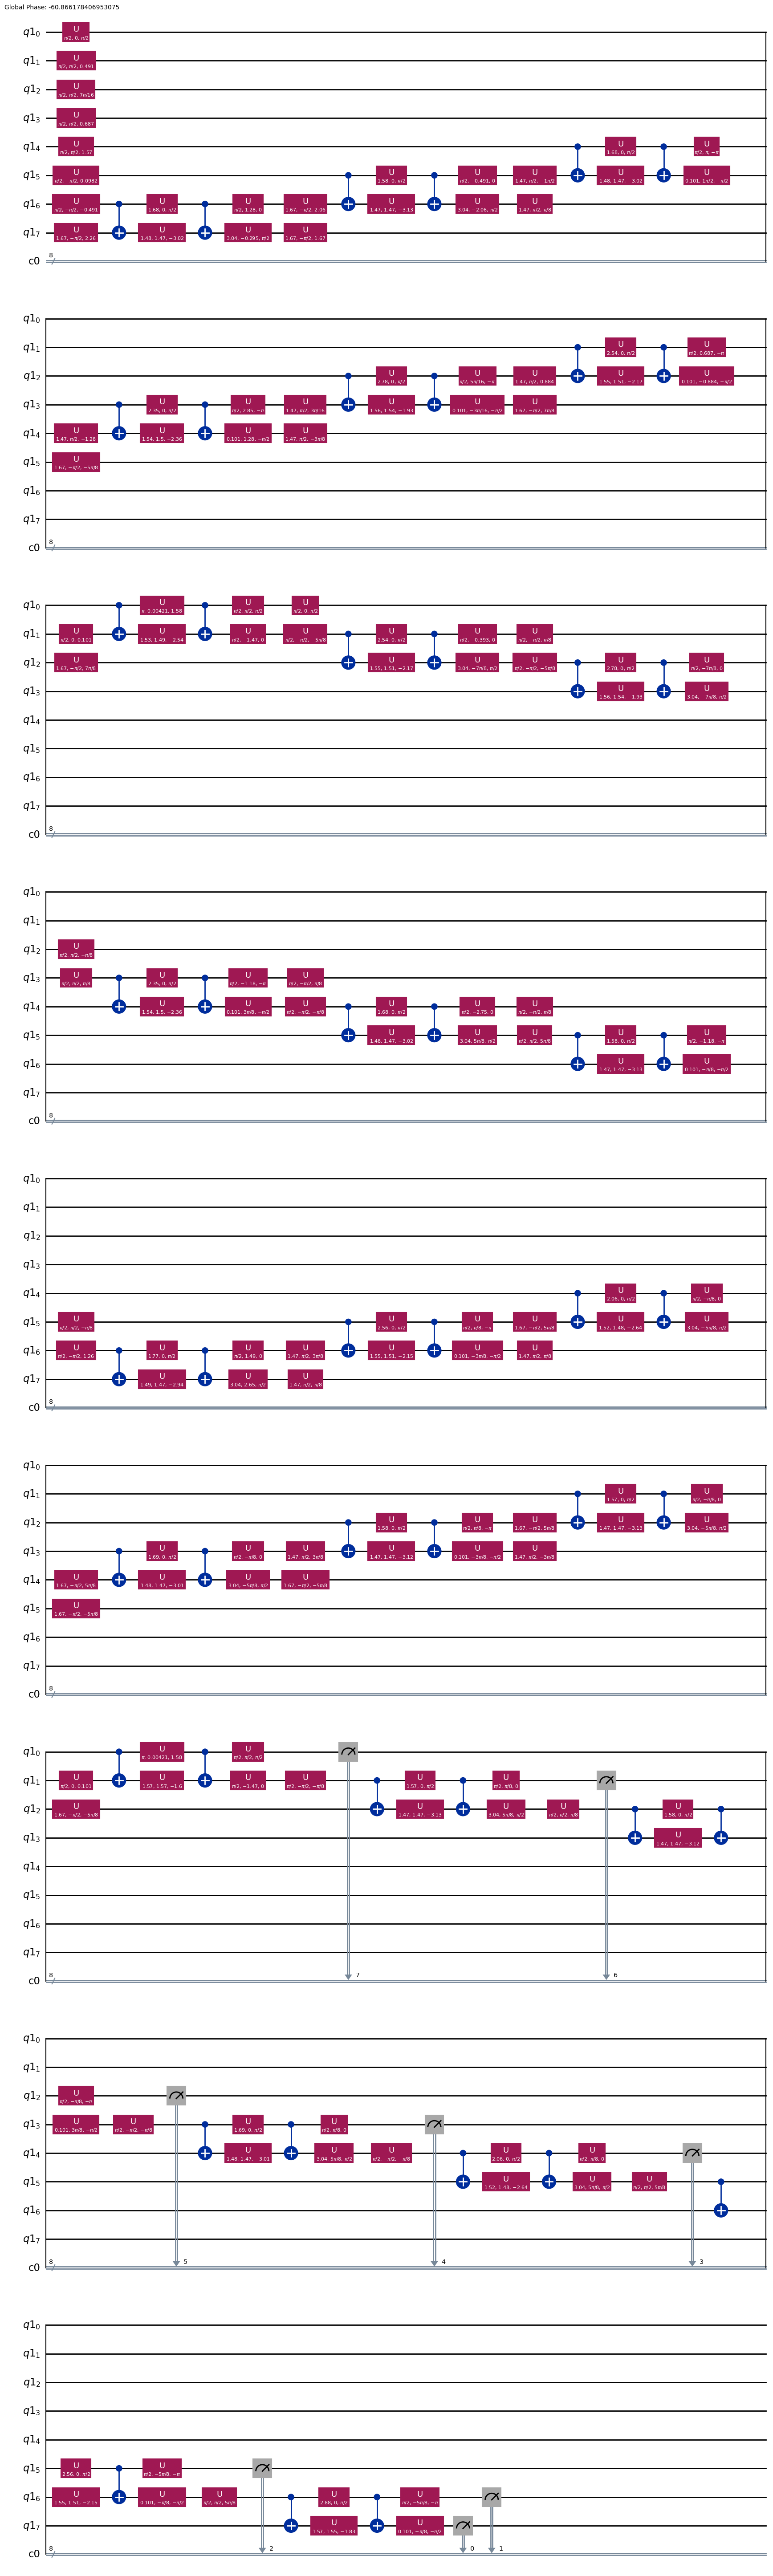

In [7]:
print("Circuit Depth: ", circuits[0].decompose().depth())
circuits[0].decompose().draw(output='mpl')

In [8]:
num_shots = 10000
job = backend.run(circuits, shots=num_shots)
counts_list = job.result().get_counts()

In [9]:
97.50*15

1462.5

In [10]:
# filename = 'qsim-free-Ns' + str(N_s)
# # filename = 'ionq-run-Feb10-Ns' + str(N_s)
# filename += '-lam' + str(lam)
# filename += '-eps' + str(hL)
# filename += '-dt' + str(dt)
# filename += '-shots' + str(num_shots)
# filename += '.json'

# import json
# with open(filename, 'w') as fout:
#     json.dump(counts_list, fout)

In [11]:
qc_occ_nums = []
for i in range(N_t):
    expecz = np.zeros(N_s)
    for key in counts_list[i]:
        for j in range(N_s):
            if key[j] == '0':
                expecz[j] += counts_list[i][key] / num_shots
            else:
                expecz[j] -= counts_list[i][key] / num_shots
    qc_occ_nums.append((1 - expecz) / 2)
qc_occ_nums = np.array(qc_occ_nums)

Text(0.5, 1.0, '(a) Initial State')

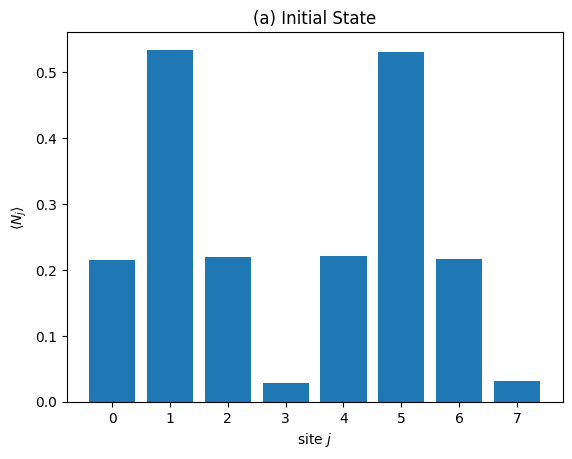

In [12]:
plt.bar(range(N_s), qc_occ_nums[0])
plt.xlabel(r'site $j$')
plt.ylabel(r'$\langle N_j \rangle$')
plt.title("(a) Initial State")

In [13]:
np.sum(qc_occ_nums[0])

2.0

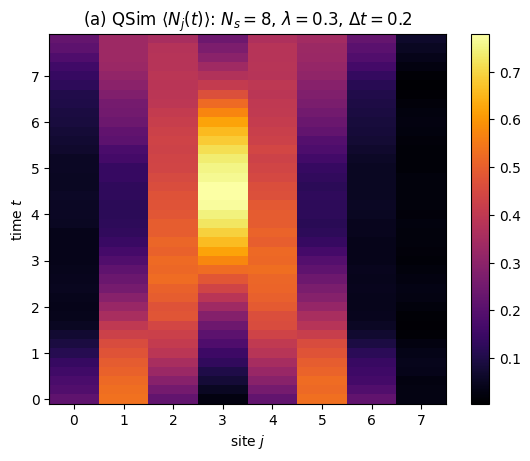

In [14]:
x = np.linspace(0, N_s-1, N_s)
y = np.linspace(0, (N_t - 1) * dt, N_t)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots()

plt.pcolormesh(X, Y, qc_occ_nums, cmap='inferno')
plt.xlabel(r'site $j$')
plt.ylabel(r'time $t$')
title = r'(a) QSim $\langle N_j (t) \rangle$: $N_s = $' + str(N_s)
title += r', $\lambda = $' + str(lam)
title += r', $\Delta t=$' + str(dt)
plt.title(title)
plt.colorbar()
# plt.savefig('qc-occ-nums.png')

In [15]:
# for i in range(N_t):
#     plt.bar(range(N_s), qc_occ_nums[i], label='Exact Trotter', color='gray')
#     plt.xlabel('s (site)')
#     plt.ylabel(r'$\langle n_s \rangle$')
#     plt.legend()
#     plt.ylim(0,1.3)
#     title = r'$N_s =$' + str(N_s)
#     title += r', $\lambda$ = ' + str(lam)
#     title += r', $t = $' + str(round(i * dt, 4))
#     plt.title(title)
#     folder = 'qc-scattering-plots/'
#     filename = folder
#     filename += 'scatt-timestep' + str(i) + '.png'
#     plt.savefig(filename)
#     plt.close()

# Exact Diagonalization

In [16]:
def build_op(N_s, site, op):
    Op = np.identity(1, dtype='complex')
    for s in range(N_s):
        if s == site:
            Op = np.kron(op, Op)
        else:
            Op = np.kron(np.identity(2, dtype='complex'), Op)
    return Op

In [17]:
x = np.array([[0, 1], [1, 0]])
y = np.array([[0, -1j], [1j, 0]])
z = np.array([[1, 0], [0, -1]])
n = np.array([[0, 0], [0, 1]])
sm = (x - 1j * y) / 2

X = []
Z = []
N = []
Sm = []

for i in range(N_s):
    X.append(build_op(N_s, i, x))
    Z.append(build_op(N_s, i, z))
    N.append(build_op(N_s, i, n))
    Sm.append(build_op(N_s, i, sm))

H_NN = np.zeros((2**N_s, 2**N_s), dtype=complex)
H_T = np.zeros((2**N_s, 2**N_s), dtype=complex)

for j in range(N_s):
    H_NN -= lam * X[j] @ X[(j + 1) % N_s]
    H_T -= Z[j]

TEO = LA.expm(-1j * dt * H_T / 2) @ LA.expm(-1j * dt * H_NN) @ LA.expm(-1j * dt * H_T / 2)

H = H_NN + H_T
Evals, Evecs = np.linalg.eigh(H)
ground_state = Evecs[:,0]

In [18]:
CDAG = []
for s in range(N_s):
    cdag = Sm[s]
    for j in range(s):
        cdag = -Z[j] @ cdag
    CDAG.append(cdag)

In [25]:
# def phi_mom(x_mean, nk_mean, nk):
#     k = nk * np.pi / N_s
#     k_mean = nk_mean * np.pi / N_s
#     return np.exp(1j * k * x_mean) * np.exp(-(k - k_mean)**2 / sig_k**2)

# def phi_pos(x_mean, x, nk_mean):
#     phi_moms = np.zeros(N_s, dtype=complex)
#     for j in range(N_s):
#         phi_moms[j] = phi_mom(x_mean, nk_mean, nks[j])
#     phi_moms /= np.linalg.norm(phi_moms)
#     phi = 0
#     for j in range(N_s):
#         phi += phi_moms[j] * np.exp(-1j * nks[j] * np.pi / N_s * x)
    # return 1/np.sqrt(N_s) * phi

x_l = [-1, 0, 1, 2, 3, 4, -3, -2]
x_r = np.roll(np.array(x_l),  4)
def GWP_coeff(x, x_dif, nk_mean, sig_k):
    k = nk_mean * np.pi / N_s
    coeff = 1 / np.sqrt(N_s) * np.exp(-1j * k * x)
    coeff *= np.exp(-x_dif[x]**2 / sig_k**2)
    return coeff

In [26]:
xr_mean = 1
xl_mean = 5
nk_mean = 3
sig_k = 3/2
nks = np.arange(-N_s + 1, N_s + 1, 2)
rm_op = np.zeros((2**N_s, 2**N_s), dtype=complex)
lm_op = np.zeros((2**N_s, 2**N_s), dtype=complex)
for j in range(N_s):
    rm_op += GWP_coeff(j, x_l, nk_mean, sig_k) * CDAG[j]
    lm_op += GWP_coeff(j, x_r, -nk_mean, sig_k) * CDAG[j]

exact_init_state = lm_op @ rm_op @ ground_state
exact_init_state /= np.linalg.norm(exact_init_state)

In [27]:
state = np.array(exact_init_state)
occs = []
for t in range(N_t):
    occ = []
    for j in range(N_s):
        occ_j = np.inner(state.conjugate(), N[j] @ state)
        occ.append(occ_j)
    occs.append(np.real(occ))
    state = TEO @ state

Text(0.5, 1.0, 'Initial State: $N_s = $8, $n_k = \\pm$3, $\\sigma_k=$1.5')

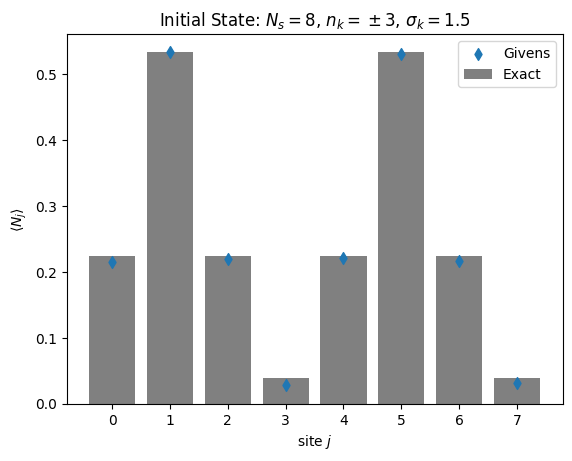

In [28]:
plt.bar(range(N_s), occs[0], color='grey', label='Exact')
plt.scatter(range(N_s), qc_occ_nums[0], marker='d', label='Givens')
plt.legend()
plt.xlabel(r'site $j$')
plt.ylabel(r'$\langle N_j \rangle$')
title = r'Initial State: '
title += r'$N_s = $' + str(N_s)
title += r', $n_k = \pm$' + str(nk_mean)
title += r', $\sigma_k=$' + str(sig_k)
plt.title(title)

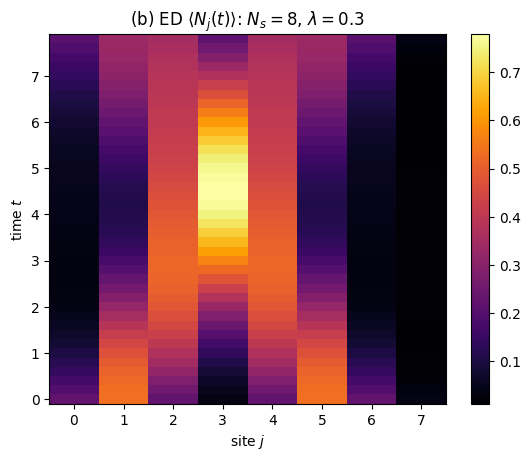

In [29]:
x = np.linspace(0, N_s-1, N_s)
y = np.linspace(0, (N_t - 1) * dt, N_t)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots()

plt.pcolormesh(X, Y, occs, cmap='inferno')
plt.xlabel(r'site $j$')
plt.ylabel(r'time $t$')
title = r'(b) ED $\langle N_j (t) \rangle$: $N_s = $' + str(N_s)
title += r', $\lambda = $' + str(lam)
# title += r', $\Delta t=$' + str(dt)
plt.title(title)
plt.colorbar()
# plt.savefig('qc-occ-nums.png')

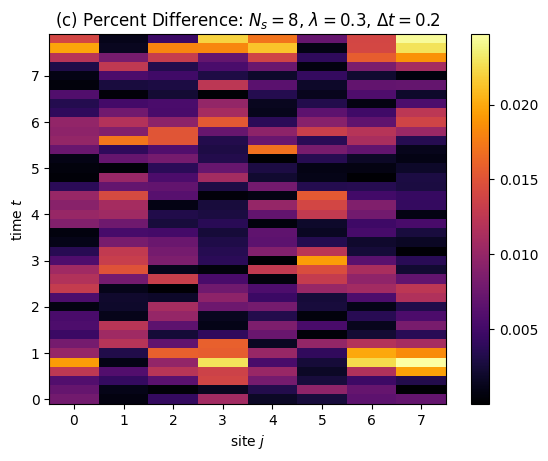

In [30]:
x = np.linspace(0, N_s-1, N_s)
y = np.linspace(0, (N_t - 1) * dt, N_t)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots()

perc_errors = []
for t in range(N_t):
    perc_error_t = []
    for j in range(N_s):
        perc_error = np.abs(occs[t][j] - qc_occ_nums[t][j])
        perc_error_t.append(perc_error)
    perc_errors.append(perc_error_t)

plt.pcolormesh(X, Y, perc_errors, cmap='inferno')
plt.xlabel(r'site $j$')
plt.ylabel(r'time $t$')
title = r'(c) Percent Difference: $N_s = $' + str(N_s)
title += r', $\lambda = $' + str(lam)
title += r', $\Delta t=$' + str(dt)
plt.title(title)
plt.colorbar()
# plt.savefig('qc-occ-nums.png')

In [31]:
ETADAG = []
n_ks = range(-N_s + 1, N_s + 1, 2)
for i in range(N_s):
    n_k = n_ks[i]
    etadag = np.zeros((2**N_s, 2**N_s), dtype='complex')
    for j in range(N_s):
        etadag += 1 / np.sqrt(N_s) * np.exp(-1j * n_k * np.pi / N_s * j) * CDAG[j]
    ETADAG.append(etadag)

In [32]:
four_spec = []
for i in range(N_s):
    for j in range(N_s):
        k_state = ETADAG[i] @ ETADAG[j] @ ground_state
        amp = np.inner(k_state.conjugate(), np.array(exact_init_state))
        four_spec.append(amp * amp.conjugate())

# plt.bar(range(N_s**2), four_spec)
# plt.xticks(ticks=n_ks) 
# plt.xlabel(r'$n_k$')
# plt.ylabel(r'$\mathcal{P}(n_k)$')
# plt.title(r'Fourier Spectrum: $k = \frac{n_k\pi}{8}$')

In [33]:
qreg = QuantumRegister(N_s)
creg = ClassicalRegister(N_s)
circ = QuantumCircuit(qreg, creg)

for i in range(N_s):
    circ.rz(betas_r[i], i)
for i in range(N_s-1):
    j = N_s - 1 - i
    circ.append(givens_circ(angles_r[i]), [j-1, j])
###
circ.x(0)
### V
for i in range(1, N_s):
    j = N_s - 1 - i
    circ.append(givens_circ_conj(angles_r[j]), [i-1, i])
for i in range(N_s):
    circ.rz(-betas_r[i], i)
###

## Left Moving Wave Packet
for i in range(N_s):
    circ.rz(betas_l[i], i)
for i in range(N_s-1):
    j = N_s - 1 - i
    circ.append(givens_circ(angles_l[i]), [j-1, j])
###
circ.x(0)
### V
for i in range(1, N_s):
    j = N_s - 1 - i
    circ.append(givens_circ_conj(angles_l[j]), [i-1, i])
for i in range(N_s):
    circ.rz(-betas_l[i], i)
from qiskit.quantum_info import Statevector
statevector = Statevector(circ).reverse_qargs()

In [34]:
init_state = []
for j in range(2**N_s):
    init_state.append(statevector[j])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/transforms.py:767: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


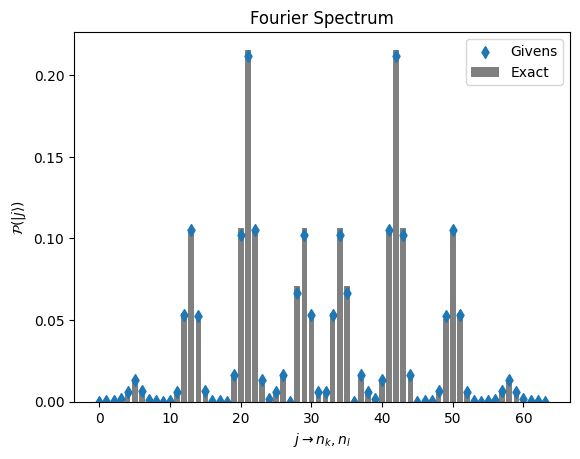

In [35]:
vac = np.zeros(2**N_s, dtype=complex)
vac[0] = 1

giv_four_spec = []
for i in range(N_s):
    for j in range(N_s):
        k_state = ETADAG[i] @ ETADAG[j] @ ground_state
        amp = np.inner(k_state.conjugate(), np.array(init_state))
        giv_four_spec.append(amp * amp.conjugate())

plt.bar(range(N_s**2), four_spec, color='grey', label='Exact')
plt.scatter(range(N_s**2), giv_four_spec, marker='d', label='Givens')
# plt.xticks(ticks=n_ks) 
plt.xlabel(r'$j \rightarrow n_k,n_{l}$')
plt.ylabel(r'$\mathcal{P}(|j\rangle)$')
plt.title(r'Fourier Spectrum')
plt.legend()